# 2H - Wash
## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error
import gpflow
from gpflow.utilities import print_summary
from sklearn.preprocessing import StandardScaler


## Read in data

In [2]:
# Read data
train = pd.read_csv('../processed_data/train.csv')
train['tpep_pickup_datetime'] = pd.to_datetime(train['tpep_pickup_datetime'])

# Grab hour interval
train['hour'] = train['tpep_pickup_datetime'].dt.hour
train['half_hour'] = train['tpep_pickup_datetime'].dt.hour + train['tpep_pickup_datetime'].dt.minute / 60
train['half_hour'] = train['half_hour'].round(1)
train = train.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
train['time_index'] = range(1, len(train) + 1)

train.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekend,weekday,hour,half_hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,,,
2022-01-24 00:00:00,89.0,218.47,7743,795.22,1143.97,2.05,61,0,2022-01-24 00:00:00,False,0,0,0.0,1
2022-01-24 06:00:00,189.0,329.97,21543,1470.24,2239.23,2.08,133,0,2022-01-24 06:00:00,False,0,6,6.0,2
2022-01-24 12:00:00,304.0,485.99,33031,2282.63,3608.66,2.16,223,0,2022-01-24 12:00:00,False,0,12,12.0,3
2022-01-24 18:00:00,306.0,596.58,35892,2522.32,4025.81,2.20,239,0,2022-01-24 18:00:00,False,0,18,18.0,4
2022-01-25 00:00:00,86.0,194.05,9596,766.80,1159.65,2.00,65,0,2022-01-25 00:00:00,False,1,0,0.0,5


In [3]:
# Read data
test = pd.read_csv('../processed_data/test.csv')
test['tpep_pickup_datetime'] = pd.to_datetime(test['tpep_pickup_datetime'])

# Grab hour interval
test['hour'] = test['tpep_pickup_datetime'].dt.hour
test['half_hour'] = test['tpep_pickup_datetime'].dt.hour + test['tpep_pickup_datetime'].dt.minute / 60
test['half_hour'] = test['half_hour'].round(1)
test = test.set_index('tpep_pickup_datetime')

# Add simple index after setting time index
test['time_index'] = range(1, len(test) + 1)
test.head()

,passenger_count,trip_distance,DOLocationID,fare_amount,total_amount,tip_amount,pickup_count,is_holiday,pickup_time,weekend,weekday,hour,half_hour,time_index
tpep_pickup_datetime,,,,,,,,,,,,,,
2024-01-22 00:00:00,102.0,267.07,11923,1304.07,1955.85,2.99,79,0,2024-01-22 00:00:00,False,0,0,0.0,1
2024-01-22 06:00:00,99.0,184.75,15382,1233.32,1824.36,2.38,91,0,2024-01-22 06:00:00,False,0,6,6.0,2
2024-01-22 12:00:00,230.0,386.35,30836,2670.74,4116.41,2.66,188,0,2024-01-22 12:00:00,False,0,12,12.0,3
2024-01-22 18:00:00,367.0,668.54,46000,4016.04,6349.92,3.00,282,0,2024-01-22 18:00:00,False,0,18,18.0,4
2024-01-23 00:00:00,103.0,202.78,9920,1230.57,1775.57,2.67,69,0,2024-01-23 00:00:00,False,1,0,0.0,5


In [4]:
# See data charactertistcs
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 904 entries, 2022-01-24 00:00:00 to 2023-05-15 18:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  904 non-null    float64
 1   trip_distance    904 non-null    float64
 2   DOLocationID     904 non-null    int64  
 3   fare_amount      904 non-null    float64
 4   total_amount     904 non-null    float64
 5   tip_amount       904 non-null    float64
 6   pickup_count     904 non-null    int64  
 7   is_holiday       904 non-null    int64  
 8   pickup_time      904 non-null    object 
 9   weekend          904 non-null    bool   
 10  weekday          904 non-null    int64  
 11  hour             904 non-null    int32  
 12  half_hour        904 non-null    float64
 13  time_index       904 non-null    int64  
dtypes: bool(1), float64(6), int32(1), int64(5), object(1)
memory usage: 96.2+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 452 entries, 2024-01-22 00:00:00 to 2024-05-13 18:00:00
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   passenger_count  452 non-null    float64
 1   trip_distance    452 non-null    float64
 2   DOLocationID     452 non-null    int64  
 3   fare_amount      452 non-null    float64
 4   total_amount     452 non-null    float64
 5   tip_amount       452 non-null    float64
 6   pickup_count     452 non-null    int64  
 7   is_holiday       452 non-null    int64  
 8   pickup_time      452 non-null    object 
 9   weekend          452 non-null    bool   
 10  weekday          452 non-null    int64  
 11  hour             452 non-null    int32  
 12  half_hour        452 non-null    float64
 13  time_index       452 non-null    int64  
dtypes: bool(1), float64(6), int32(1), int64(5), object(1)
memory usage: 48.1+ KB


In [6]:
## SHRINK SIZES IF NECESSARY
#train = train[:1000]
#test = test[:1000]

## EDA

In [7]:
train.groupby('hour')['pickup_count'].mean()

hour
0     323.022124
6     122.159292
12    331.371681
18    606.389381
Name: pickup_count, dtype: float64

In [8]:
test.groupby('hour')['pickup_count'].mean()

hour
0     486.079646
6     113.115044
12    318.407080
18    721.079646
Name: pickup_count, dtype: float64

## Plot general Time Series

## Over chosen time interval

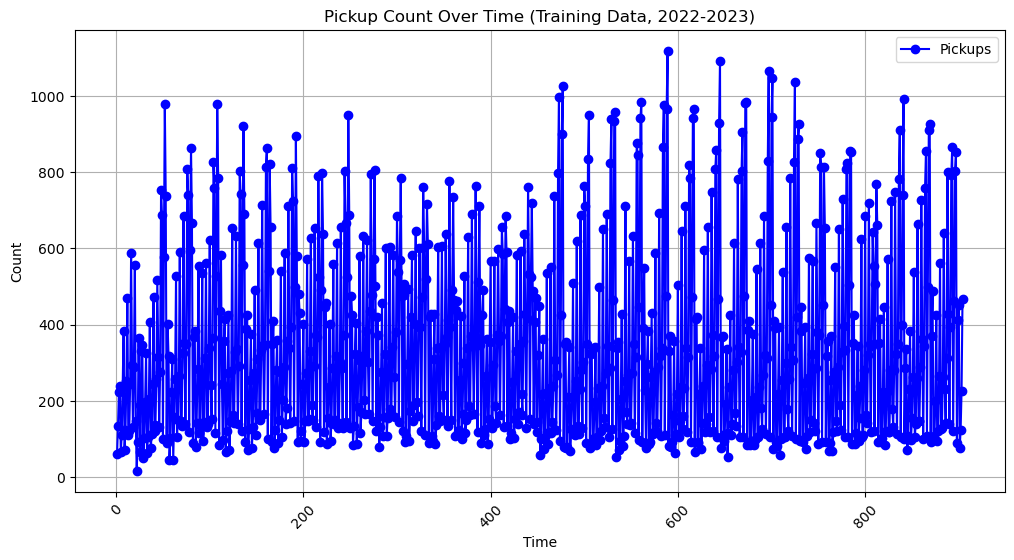

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'], train['pickup_count'], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, 2022-2023)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

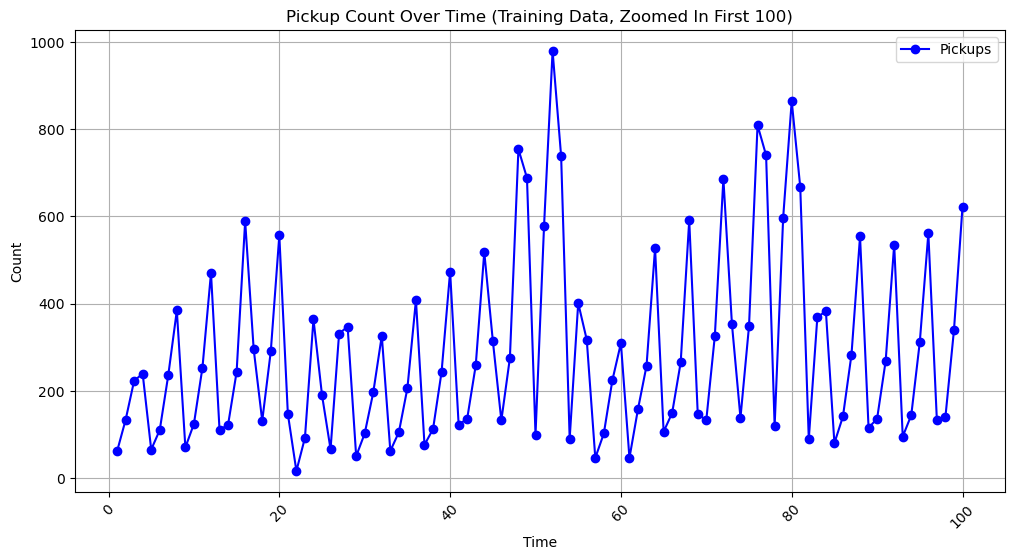

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'][:100], train['pickup_count'][:100], marker='o', label='Pickups', color='blue')
plt.title('Pickup Count Over Time (Training Data, Zoomed In First 100)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

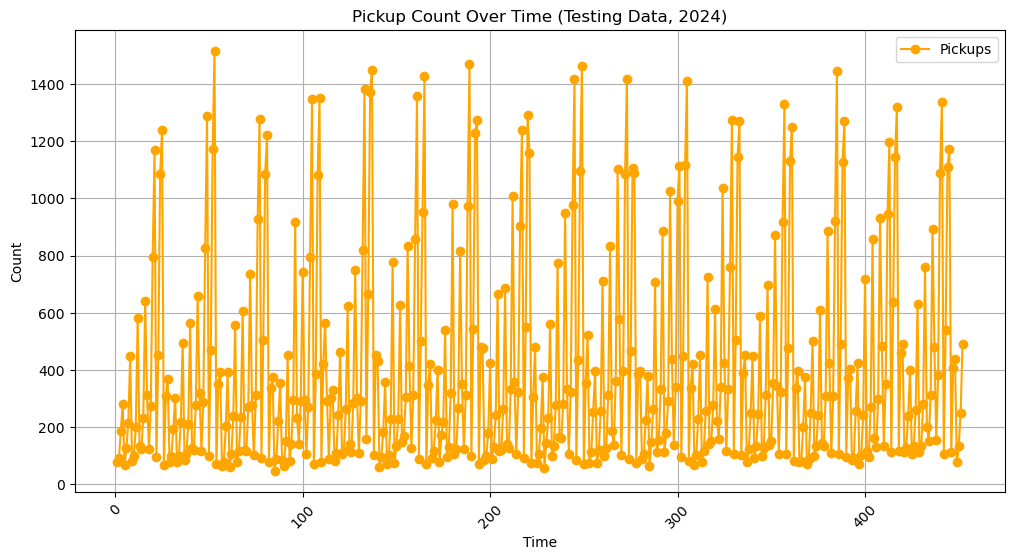

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(test['time_index'], test['pickup_count'], marker='o', label='Pickups', color='orange')
plt.title('Pickup Count Over Time (Testing Data, 2024)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

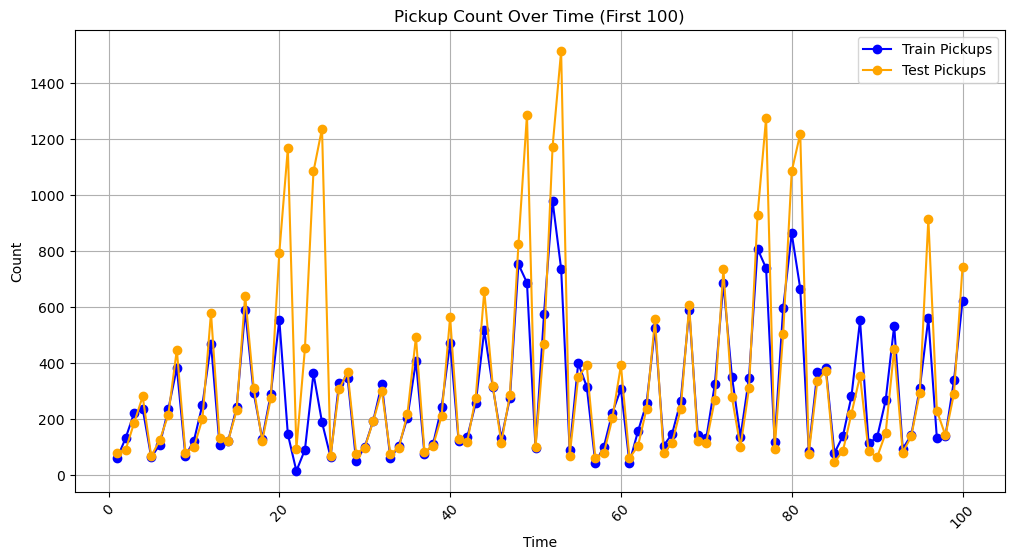

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(train['time_index'][:100], train['pickup_count'][:100], marker='o', label='Train Pickups', color='blue')
plt.plot(test['time_index'][:100], test['pickup_count'][:100], marker='o', label='Test Pickups', color='orange')
plt.title('Pickup Count Over Time (First 100)')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

## Over the hour

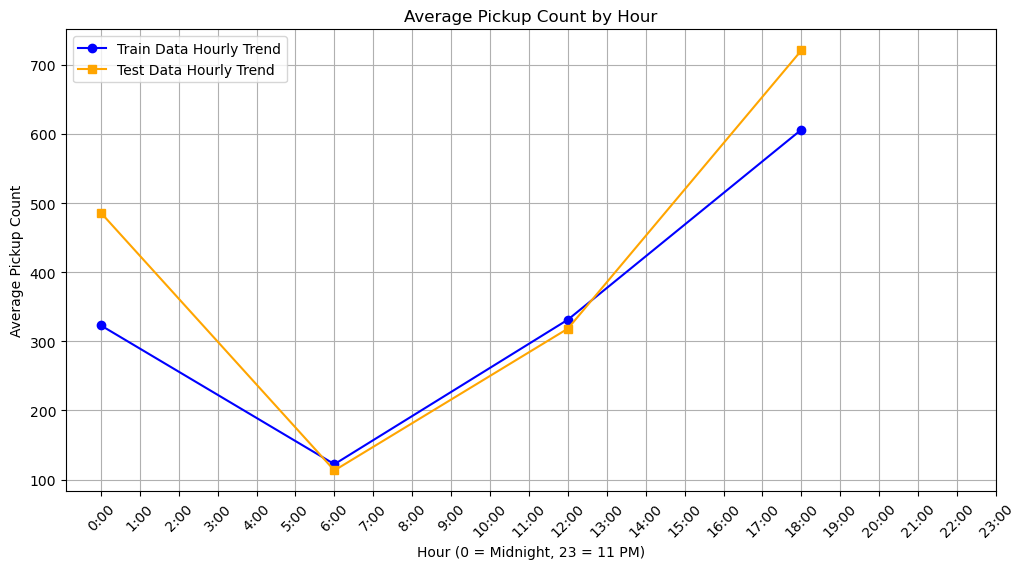

In [13]:
# Group by hour and calculate the mean pickup count for each hour
hourly_trend_train = train.groupby('hour')['pickup_count'].mean()
hourly_trend_test = test.groupby('hour')['pickup_count'].mean()

# Plot hourly trend
plt.figure(figsize=(12, 6))
plt.plot(
    hourly_trend_train.index,
    hourly_trend_train.values,
    marker='o',
    label='Train Data Hourly Trend',
    color='blue'
)
plt.plot(
    hourly_trend_test.index,
    hourly_trend_test.values,
    marker='s',
    label='Test Data Hourly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Hour')
plt.xlabel('Hour (0 = Midnight, 23 = 11 PM)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(0, 24),
    labels=[f'{h}:00' for h in range(0, 24)],  # Formats hour labels as '0:00', '1:00', etc.
    rotation=45
)
plt.grid()
plt.legend()
plt.show()

## Over each weekday

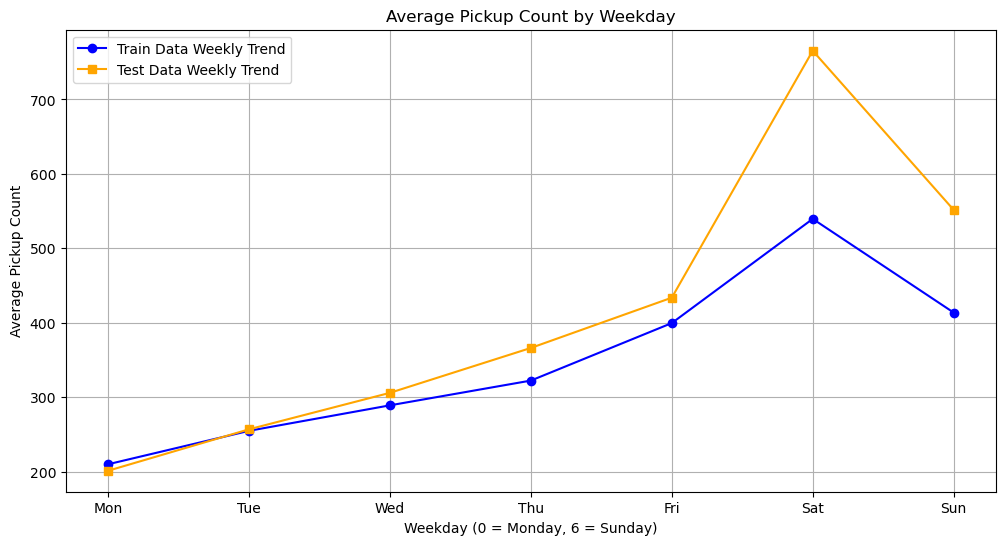

In [14]:
# Group by weekday and calculate the mean pickup count for each weekday
weekly_trend_train = train.groupby('weekday')['pickup_count'].mean()
weekly_trend_test = test.groupby('weekday')['pickup_count'].mean()

# Plot weekly trend
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_trend_train.index,
    weekly_trend_train.values,
    marker='o',
    label='Train Data Weekly Trend',
    color='blue'
)
plt.plot(
    weekly_trend_test.index,
    weekly_trend_test.values,
    marker='s',
    label='Test Data Weekly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Weekday')
plt.xlabel('Weekday (0 = Monday, 6 = Sunday)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=weekly_trend_train.index,
    labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
plt.grid()
plt.legend()
plt.show()


## Over the weeks

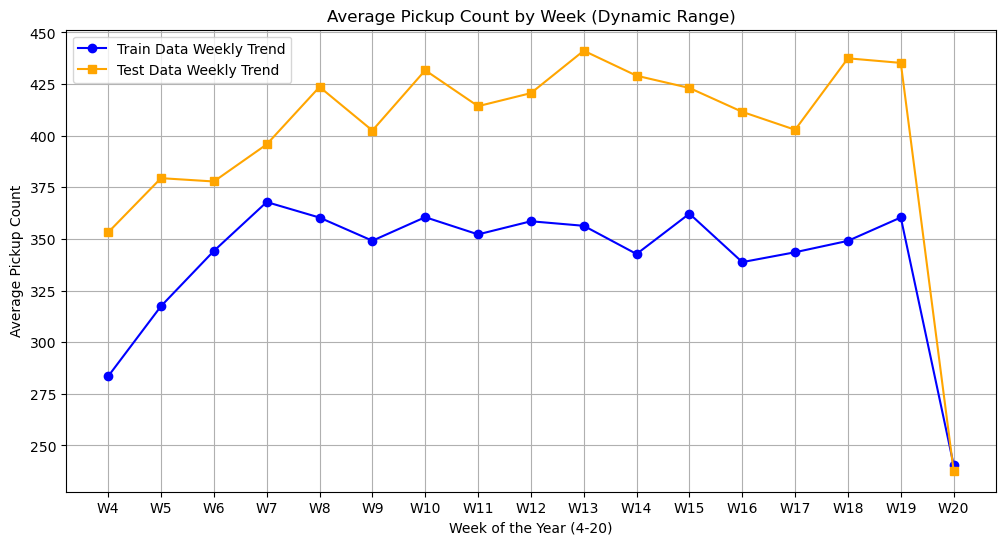

In [15]:
# Group by week of the year and calculate the mean pickup count for each week
train['pickup_time'] = pd.to_datetime(train['pickup_time'])
test['pickup_time'] = pd.to_datetime(test['pickup_time'])
train['week'] = train['pickup_time'].dt.isocalendar().week
test['week'] = test['pickup_time'].dt.isocalendar().week

# Determine the min and max week from both datasets
min_week = min(train['week'].min(), test['week'].min())
max_week = max(train['week'].max(), test['week'].max())

# Group by week for the range of weeks in the data
weekly_trend_train = train.groupby('week')['pickup_count'].mean()
weekly_trend_test = test.groupby('week')['pickup_count'].mean()

# Plot weekly trend
plt.figure(figsize=(12, 6))
plt.plot(
    weekly_trend_train.index,
    weekly_trend_train.values,
    marker='o',
    label='Train Data Weekly Trend',
    color='blue'
)
plt.plot(
    weekly_trend_test.index,
    weekly_trend_test.values,
    marker='s',
    label='Test Data Weekly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Week (Dynamic Range)')
plt.xlabel(f'Week of the Year ({min_week}-{max_week})')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(min_week, max_week + 1, max(1, (max_week - min_week) // 10)),  # Adjust ticks dynamically
    labels=[f'W{k}' for k in range(min_week, max_week + 1, max(1, (max_week - min_week) // 10))]
)
plt.grid()
plt.legend()
plt.show()


## Over the month

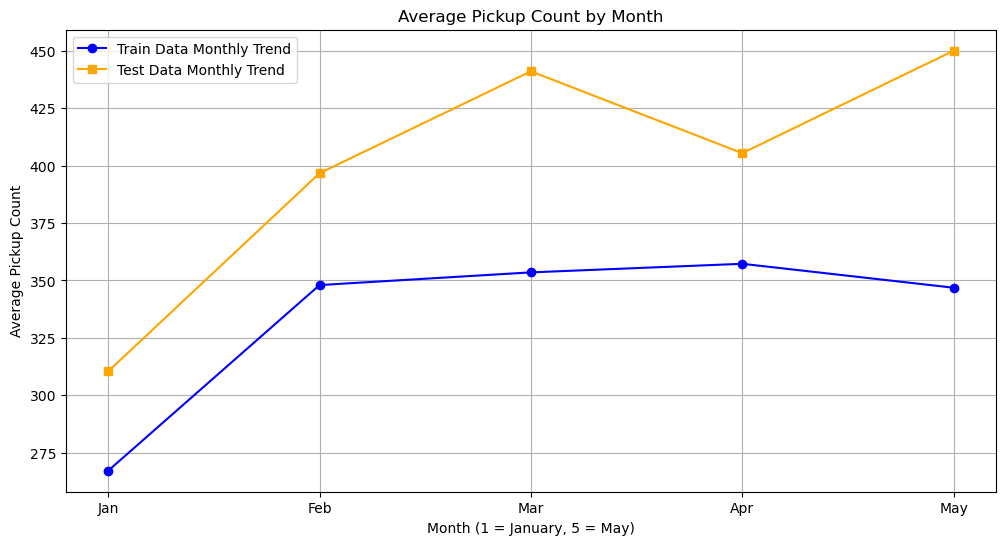

In [16]:
# Group by month and calculate the mean pickup count for each month
monthly_trend_train = train.groupby(train['pickup_time'].dt.month)['pickup_count'].mean()
monthly_trend_test = test.groupby(test['pickup_time'].dt.month)['pickup_count'].mean()

# Plot monthly trend
plt.figure(figsize=(12, 6))
plt.plot(
    monthly_trend_train.index,
    monthly_trend_train.values,
    marker='o',
    label='Train Data Monthly Trend',
    color='blue'
)
plt.plot(
    monthly_trend_test.index,
    monthly_trend_test.values,
    marker='s',
    label='Test Data Monthly Trend',
    color='orange'
)
plt.title('Average Pickup Count by Month')
plt.xlabel('Month (1 = January, 5 = May)')
plt.ylabel('Average Pickup Count')
plt.xticks(
    ticks=range(1, 6),
    labels=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May'
    ]
)
plt.grid()
plt.legend()
plt.show()


## Model Fitting - try GP

## All vars

In [17]:
# Features (X) - Including the new feature
## Let's try the hstack method
train['year'] = train['pickup_time'].dt.year  # Extract year from pickup_time
train_by_year = [group[['hour', 'weekday']].values for _, group in train.groupby('year')]
X_train = np.hstack(train_by_year)[:,0:2]  # Horizontally stack features by year

test['year'] = test['pickup_time'].dt.year  # Extract year from pickup_time
test_by_year = [group[['hour', 'weekday']].values for _, group in test.groupby('year')]
X_test = np.hstack(test_by_year)  # Horizontally stack features by year


# X_train
#X_train = train[['hour', 'weekday']].values
#X_test = test[['hour', 'weekday']].values

# Features (X) - All columns except 'pickup_count'
#X_train = train[['hour']].values
#X_test = test[['hour']].values

# Target (y) - 'pickup_count'
# Subtract the mean function (use training data)
train_by_year = [group[['pickup_count']].values for _, group in train.groupby('year')]
y_train = np.hstack(train_by_year).mean(axis=1)  # Horizontally stack features by year

# Target (y)
mean_func = train['pickup_count'].mean()
#y_train = train['pickup_count'].values.astype(np.float64)  # Ensure float64 type for compatibility
y_test = test['pickup_count'].values.astype(np.float64)  # Also ensure float64 for consistenc

# Scale features if necessary (important for GP models to avoid dominance of larger scale features)
## HERE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#print(X_scaled)

In [18]:
X_train

array([[-1.34164079, -1.47869908],
       [-0.4472136 , -1.47869908],
       [ 0.4472136 , -1.47869908],
       [ 1.34164079, -1.47869908],
       [-1.34164079, -0.9813985 ],
       [-0.4472136 , -0.9813985 ],
       [ 0.4472136 , -0.9813985 ],
       [ 1.34164079, -0.9813985 ],
       [-1.34164079, -0.48409791],
       [-0.4472136 , -0.48409791],
       [ 0.4472136 , -0.48409791],
       [ 1.34164079, -0.48409791],
       [-1.34164079,  0.01320267],
       [-0.4472136 ,  0.01320267],
       [ 0.4472136 ,  0.01320267],
       [ 1.34164079,  0.01320267],
       [-1.34164079,  0.51050325],
       [-0.4472136 ,  0.51050325],
       [ 0.4472136 ,  0.51050325],
       [ 1.34164079,  0.51050325],
       [-1.34164079,  1.00780384],
       [-0.4472136 ,  1.00780384],
       [ 0.4472136 ,  1.00780384],
       [ 1.34164079,  1.00780384],
       [-1.34164079,  1.50510442],
       [-0.4472136 ,  1.50510442],
       [ 0.4472136 ,  1.50510442],
       [ 1.34164079,  1.50510442],
       [-1.34164079,

In [19]:
y_train

array([ 59.5, 116. , 220. , 300.5,  69.5, 107.5, 228. , 459.5,  78.5,
       121. , 243.5, 510.5, 113.5, 133.5, 241.5, 663.5, 300.5, 127. ,
       278.5, 677. , 571.5,  56. , 258. , 632. , 608. ,  72.5, 340. ,
       350.5,  63.5,  90.5, 203. , 333.5,  65. , 116. , 207.5, 458.5,
        95. , 111. , 247. , 546. , 128. , 125. , 244.5, 603. , 297.5,
       130. , 288. , 759. , 699. ,  94.5, 463.5, 907. , 844. ,  83. ,
       361.5, 324.5,  65.5, 102. , 210.5, 325.5,  65. , 131. , 245. ,
       513.5, 101.5, 135. , 252. , 620.5, 150.5, 132. , 299.5, 687.5,
       348. , 122. , 317.5, 816.5, 839.5, 122. , 530.5, 899.5, 813. ,
        70.5, 353. , 368.5,  75.5, 118.5, 243.5, 491.5,  98. , 121.5,
       260.5, 623.5, 133. , 142. , 290.5, 564.5, 134. , 140.5, 306. ,
       627. , 296. , 134.5, 339.5, 851.5, 801. , 107.5, 486. , 960.5,
       885. ,  88.5, 414.5, 565.5, 235.5,  87. , 327. , 400. ,  76.5,
       106.5, 268.5, 428.5,  91. , 132. , 277. , 621.5, 152.5, 132.5,
       307.5, 663. ,

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((452, 2), (452,), (452, 2), (452,))

In [21]:
# GPFlow model
# Combine squared exponential kernel with sinusoidal kernel
squared_exponential = gpflow.kernels.SquaredExponential()
sinusoidal = gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(), period=2)
white_noise = gpflow.kernels.White()
kernel = squared_exponential + sinusoidal + white_noise

mean_func = y_train.reshape(-1,1).mean()

# Define the GP regression model
model = gpflow.models.GPR(data=(X_train, (y_train.reshape(-1, 1) - mean_func)), kernel=kernel, mean_function=None)

# Optimize the model using Scipy optimizer
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, variables=model.trainable_variables)

# Print the summary of the kernel
print_summary(model)

# Predictions
mean, variance = model.predict_f(X_test)
y_pred = mean.numpy().flatten() + mean_func
sigma = np.sqrt(variance.numpy()).flatten()

╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │           value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════╡
│ GPR.kernel.kernels[0].variance                 │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 24021.6         │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────┤
│ GPR.kernel.kernels[0].lengthscales             │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     0.775455    │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────

Root Mean Squared Error: 182.466
MAPE: 0.182


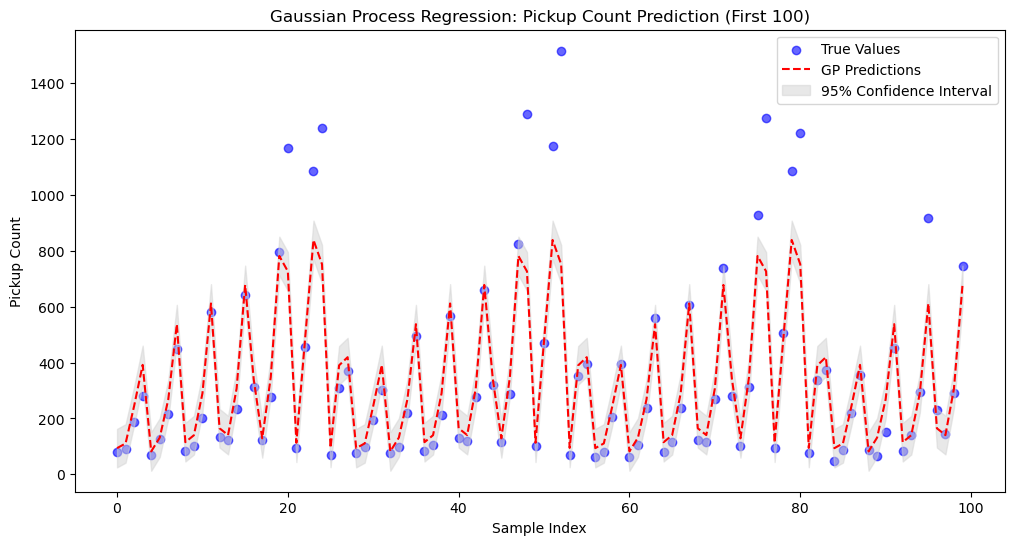

Sigma
35.19190814596175


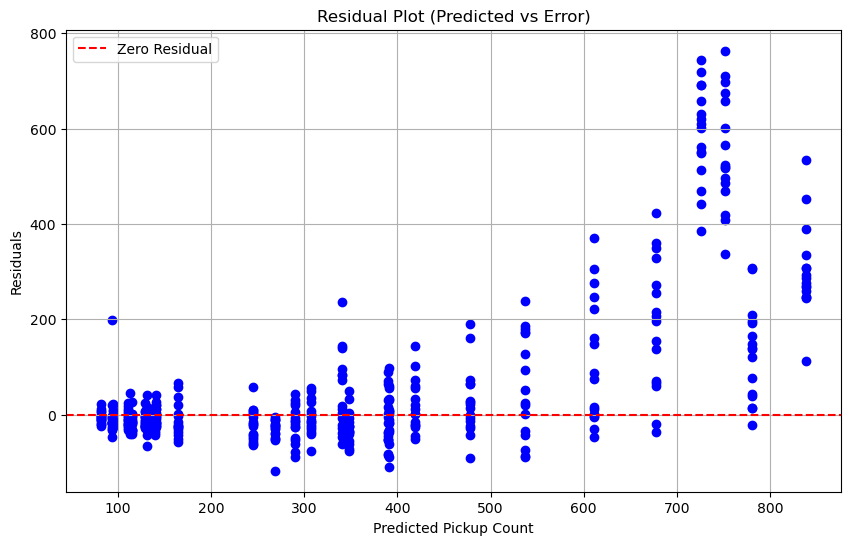

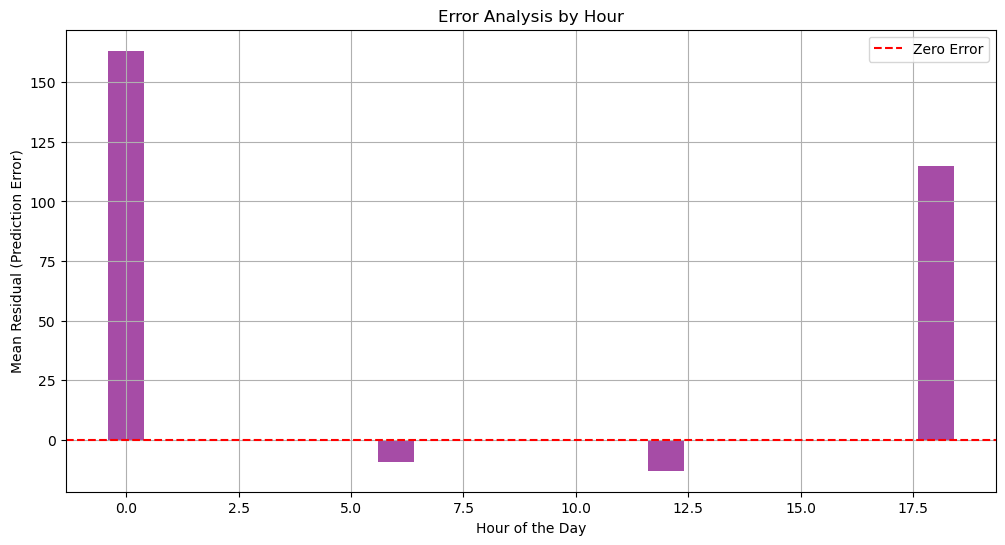

In [22]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# 95% interval mean
#95
print(sigma.mean() * 1.96)

# Sigma
print(sigma.mean())

68.97613996608503
35.19190814596175


Root Mean Squared Error: 182.466
MAPE: 0.182


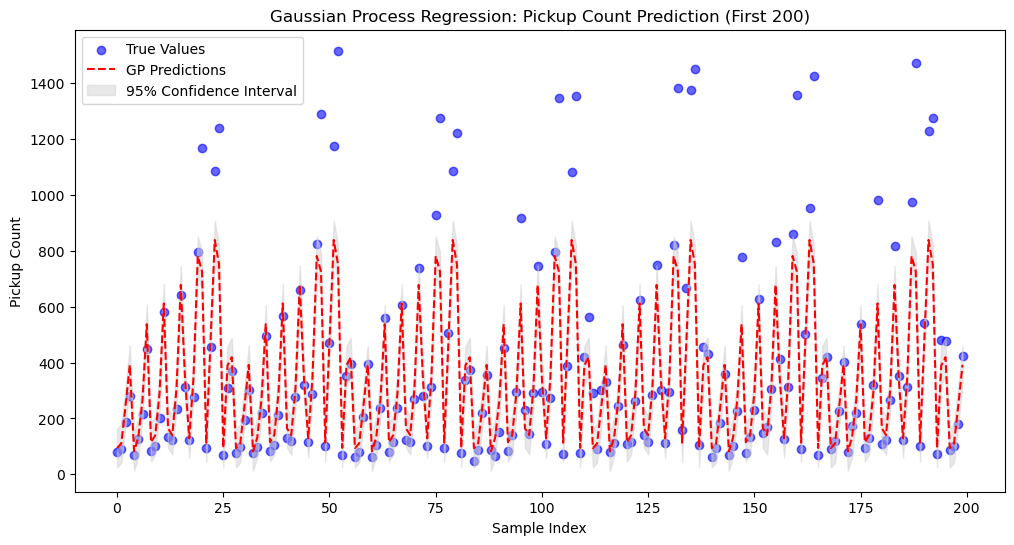

Sigma
35.19190814596175


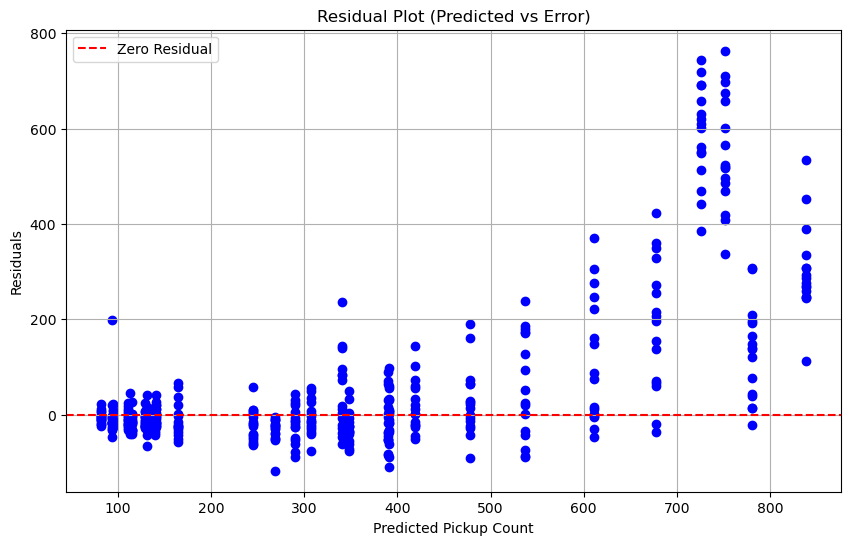

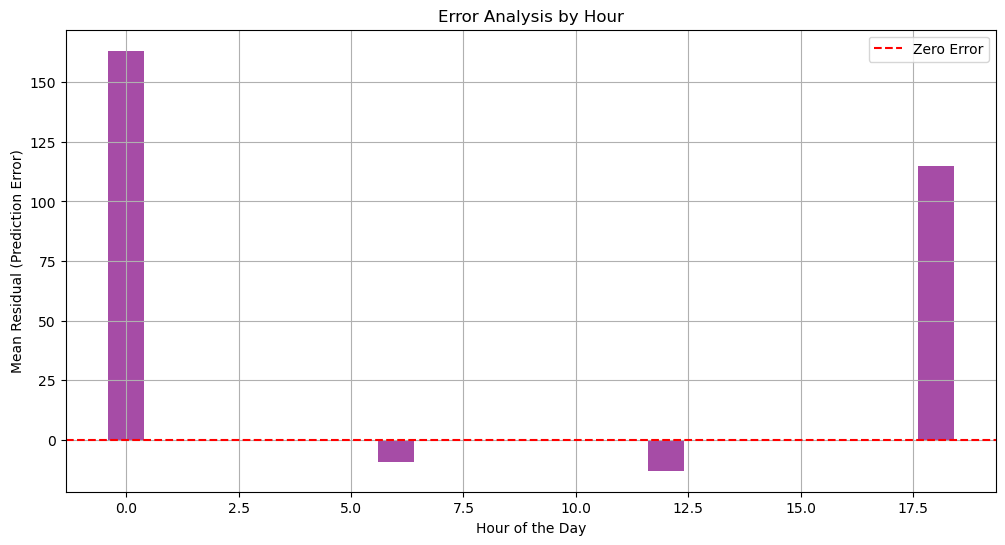

In [24]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:200])), y_test[:200], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:200])), y_pred[:200], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:200])),
    y_pred[:200] - 1.96 * sigma[:200],
    y_pred[:200] + 1.96 * sigma[:200],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 200)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()


## Simpler

In [25]:
# GPFlow model
# Combine squared exponential kernel with sinusoidal kernel
sinusoidal = gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential(), period=2)
white_noise = gpflow.kernels.White()
kernel = sinusoidal + white_noise

mean_func = y_train.reshape(-1,1).mean()

# Define the GP regression model
model = gpflow.models.GPR(data=(X_train, (y_train.reshape(-1, 1) - mean_func)), kernel=kernel, mean_function=None)

# Optimize the model using Scipy optimizer
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, variables=model.trainable_variables)

# Print the summary of the kernel
print_summary(model)

# Predictions
mean, variance = model.predict_f(X_test)
y_pred = mean.numpy().flatten() + mean_func
sigma = np.sqrt(variance.numpy()).flatten()

╒════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                                           │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].base_kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 73020.3      │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].base_kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │     0.533242 │
├────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.

Root Mean Squared Error: 182.726
MAPE: 0.182


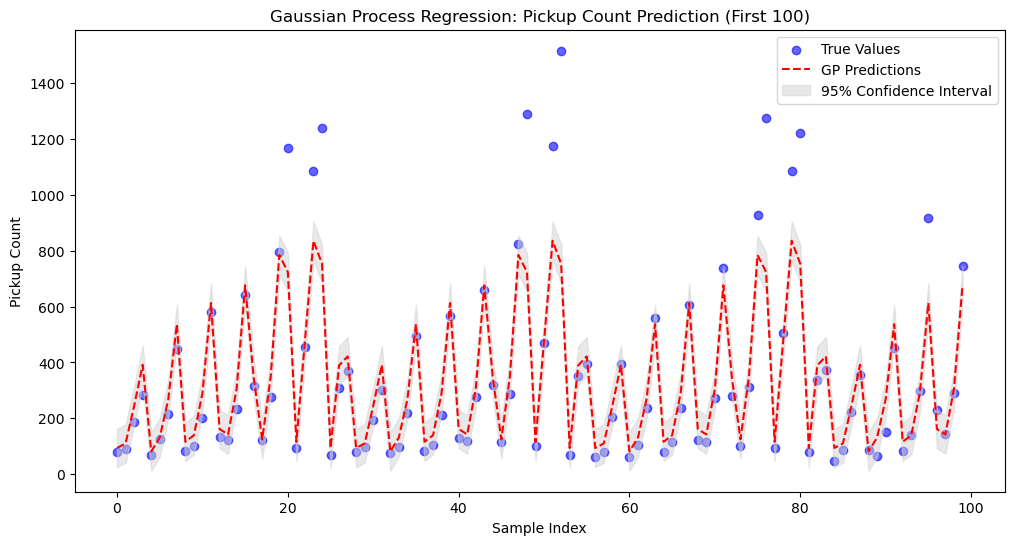

Sigma
35.09425525353901


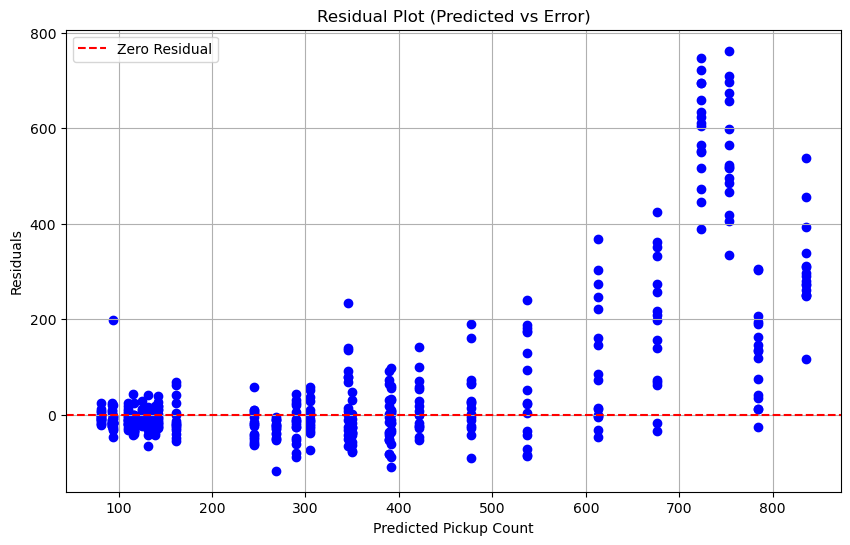

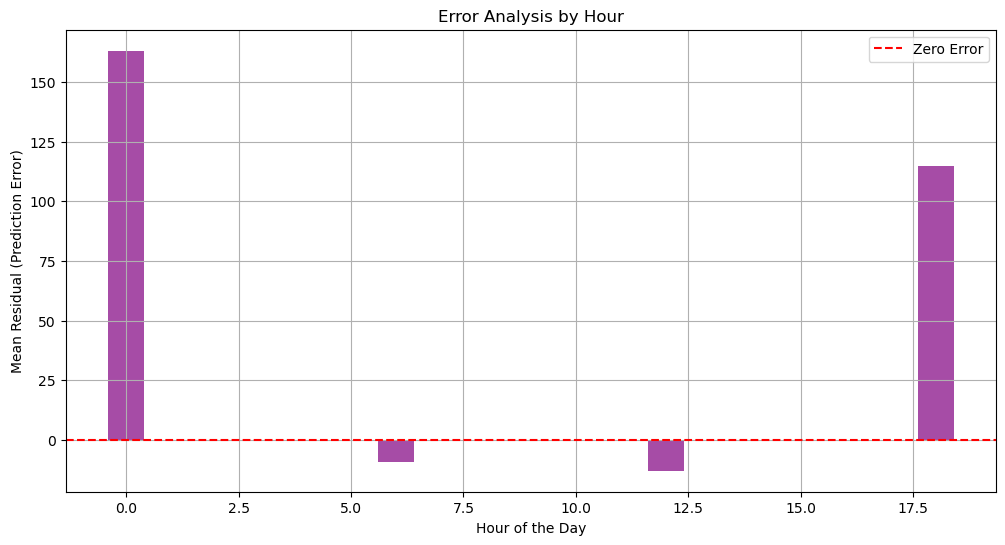

Root Mean Squared Error: 182.726
MAPE: 0.182


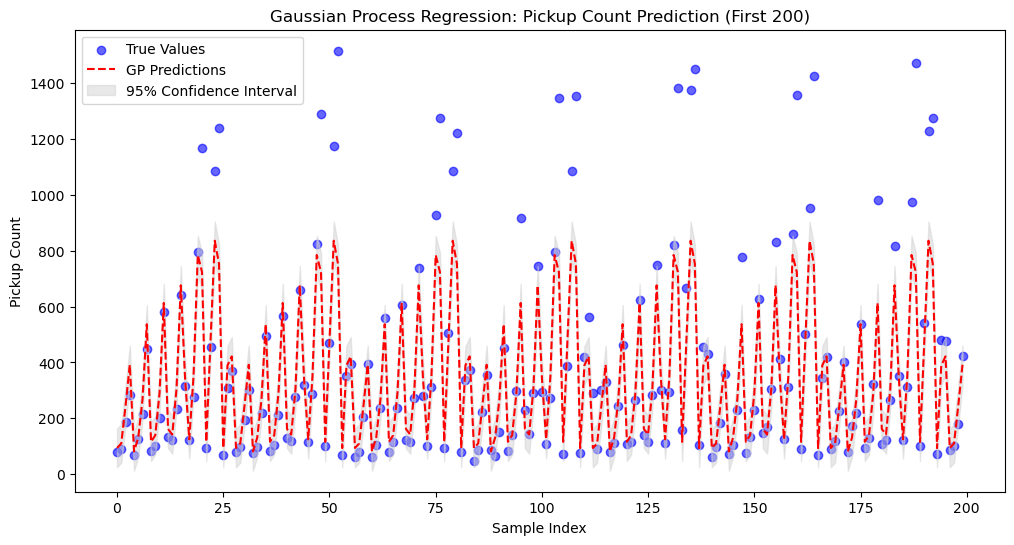

Sigma
35.09425525353901


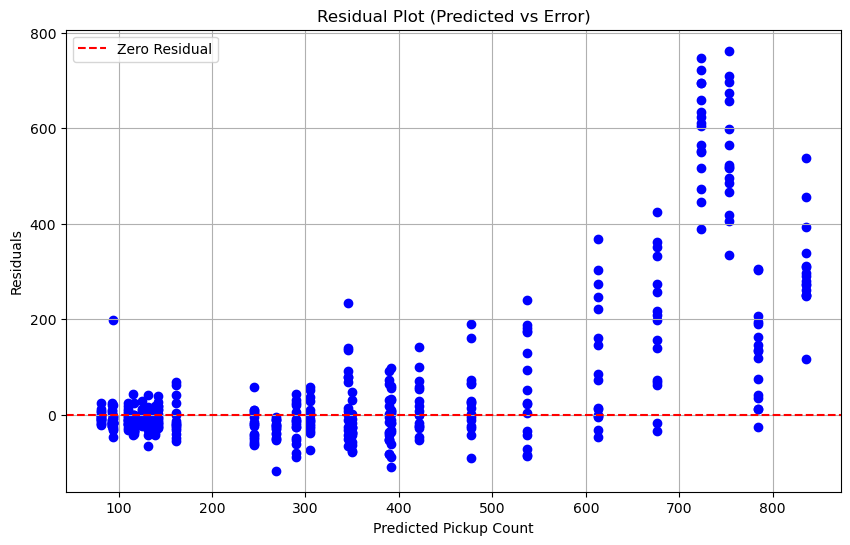

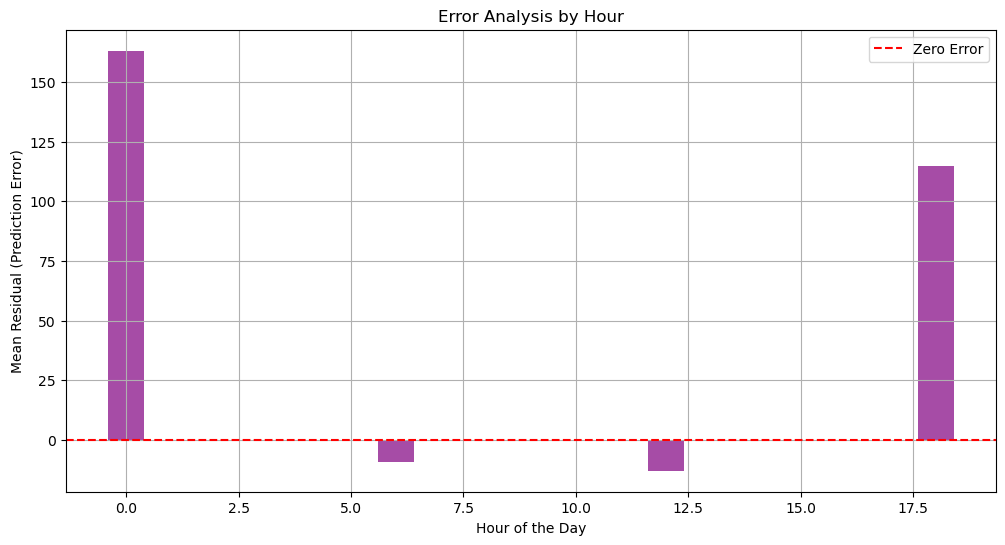

68.78474029693646
35.09425525353901


In [26]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:100])), y_test[:100], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:100])), y_pred[:100], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:100])),
    y_pred[:100] - 1.96 * sigma[:100],
    y_pred[:100] + 1.96 * sigma[:100],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 100)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:200])), y_test[:200], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:200])), y_pred[:200], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:200])),
    y_pred[:200] - 1.96 * sigma[:200],
    y_pred[:200] + 1.96 * sigma[:200],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 200)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()

# 95% interval mean
#95
print(sigma.mean() * 1.96)

# Sigma
print(sigma.mean())



Root Mean Squared Error: 182.726
MAPE: 0.182


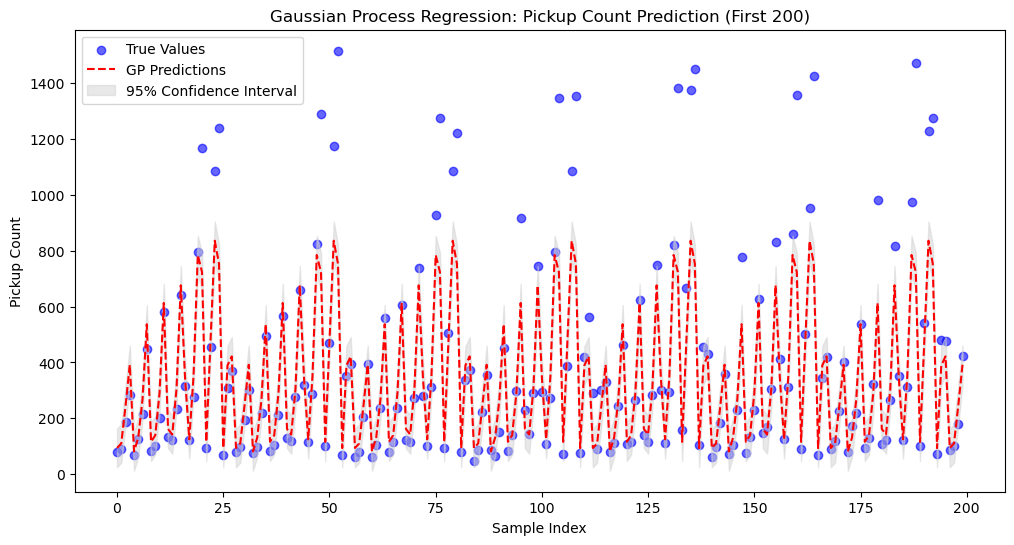

Sigma
35.09425525353901


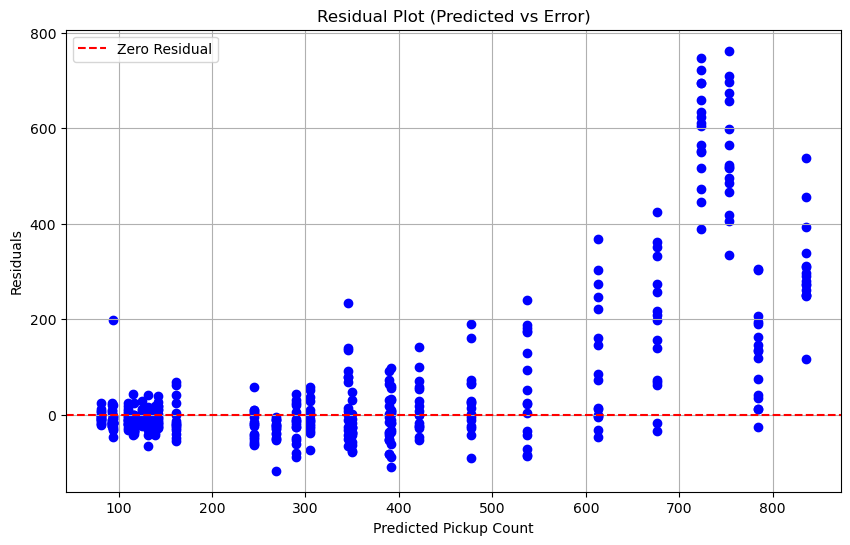

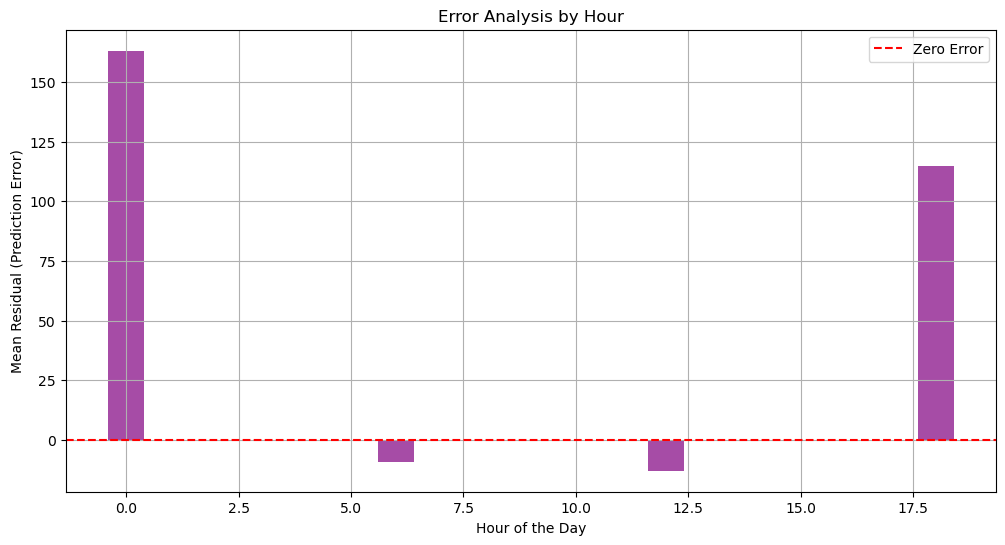

68.78474029693646
35.09425525353901


In [27]:
rmse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.3f}")
print(f"MAPE: {mape:.3f}")

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test[:200])), y_test[:200], label="True Values", color="blue", alpha=0.6)
plt.plot(range(len(y_pred[:200])), y_pred[:200], label="GP Predictions", color="red", linestyle="dashed")
plt.fill_between(
    range(len(y_pred[:200])),
    y_pred[:200] - 1.96 * sigma[:200],
    y_pred[:200] + 1.96 * sigma[:200],
    color="lightgrey",
    alpha=0.5,
    label="95% Confidence Interval",
)
plt.xlabel("Sample Index")
plt.ylabel("Pickup Count")
plt.title("Gaussian Process Regression: Pickup Count Prediction (First 200)")
plt.legend()
plt.show()

print("Sigma")
print(sigma.mean())

# Compute residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()

# Error Analysis Over the Hour
test['hour'] = test['pickup_time'].dt.hour
error_by_hour = test.assign(residual=residuals).groupby('hour')['residual'].mean()

plt.figure(figsize=(12, 6))
plt.bar(error_by_hour.index, error_by_hour.values, color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel("Hour of the Day")
plt.ylabel("Mean Residual (Prediction Error)")
plt.title(f"Error Analysis by Hour")
plt.legend()
plt.grid(True)
plt.show()

# 95% interval mean
#95
print(sigma.mean() * 1.96)

# Sigma
print(sigma.mean())
